### Import Modules

In [42]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import cv2


ROOT_DIR = os.path.join(os.curdir, '..', '..')

### Load Data

In [3]:
KAGGLE_ANNO = os.path.join(ROOT_DIR, r'data/pcb_defects_kaggle/Annotations/annotation_summary.csv')

kaggle_data = pd.read_csv(KAGGLE_ANNO, sep=';') 

,Unnamed: 0,class,xmin,ymin,xmax,ymax,file,defect_x_center,defect_y_center,defect_width,defect_height,image_width,image_height,width_ratio,height_ratio,path,category_codes
1659,1659,short,1199,1085,1257,1136,.\data\pcb_defects_kaggle\Annotations\Short\06...,0.428173,0.479491,58,51,2868,2316,0.020223,0.022021,.\data\pcb_defects_kaggle\images/Short/06_shor...,4
1255,1255,open_circuit,379,987,425,1027,.\data\pcb_defects_kaggle\Annotations\Open_cir...,0.145705,0.467502,46,40,2759,2154,0.016673,0.018570,.\data\pcb_defects_kaggle\images/Open_circuit/...,3
174,174,missing_hole,2428,1317,2489,1380,.\data\pcb_defects_kaggle\Annotations\Missing_...,0.857218,0.582254,61,63,2868,2316,0.021269,0.027202,.\data\pcb_defects_kaggle\images/Missing_hole/...,1
2843,2843,spurious_copper,1719,1022,1759,1121,.\data\pcb_defects_kaggle\Annotations\Spurious...,0.776339,0.531498,40,99,2240,2016,0.017857,0.049107,.\data\pcb_defects_kaggle\images/Spurious_copp...,6
857,857,mouse_bite,1300,1494,1390,1541,.\data\pcb_defects_kaggle\Annotations\Mouse_bi...,0.484685,0.702872,90,47,2775,2159,0.032432,0.021769,.\data\pcb_defects_kaggle\images/Mouse_bite/09...,2
256,256,missing_hole,2034,515,2113,601,.\data\pcb_defects_kaggle\Annotations\Missing_...,0.714015,0.290474,79,86,2904,1921,0.027204,0.044768,.\data\pcb_defects_kaggle\images/Missing_hole/...,1
2448,2448,spur,2073,1864,2175,1914,.\data\pcb_defects_kaggle\Annotations\Spur\12_...,0.839858,0.746640,102,50,2529,2530,0.040332,0.019763,.\data\pcb_defects_kaggle\images/Spur/12_spur_...,5
430,430,missing_hole,1317,1542,1380,1617,.\data\pcb_defects_kaggle\Annotations\Missing_...,0.590929,0.702625,63,75,2282,2248,0.027607,0.033363,.\data\pcb_defects_kaggle\images/Missing_hole/...,1
1461,1461,open_circuit,1453,419,1498,477,.\data\pcb_defects_kaggle\Annotations\Open_cir...,0.583432,0.177075,45,58,2529,2530,0.017794,0.022925,.\data\pcb_defects_kaggle\images/Open_circuit/...,3


### Plotting Function


In [77]:
def plot_images_from_dataset(image_dataset, title='Images'):
    """
    Plots 9 images from the given TensorFlow dataset.
    
    Parameters:
    - image_dataset: TensorFlow dataset containing the images.
    - Title: Plot title.
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    for i, image in enumerate(image_dataset.take(9)):
        axes[i].imshow(image.numpy())
        axes[i].axis('off')
        
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.9)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

### Decode Images to Tensorflow Dataset

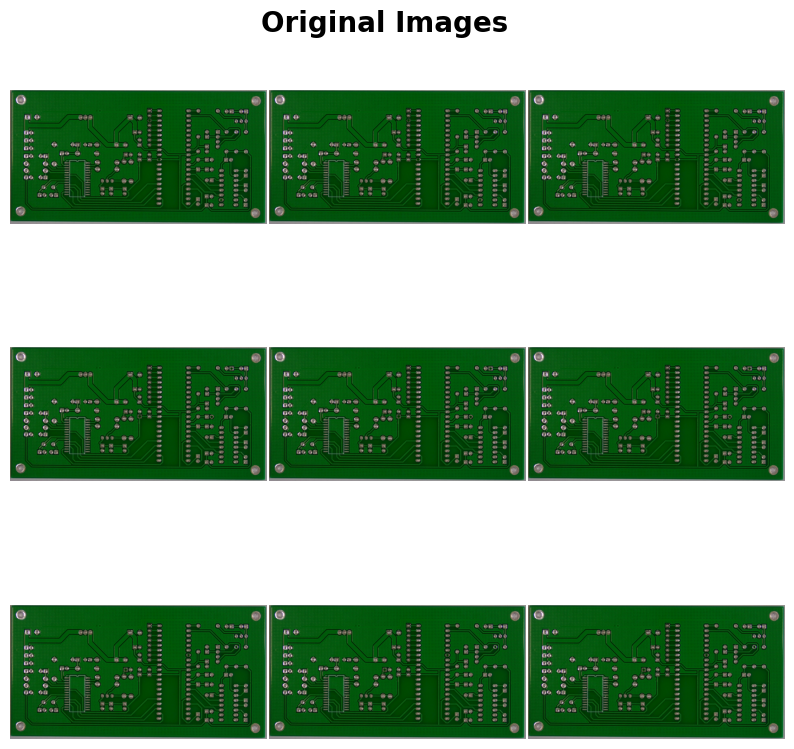

In [78]:
def load_and_decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

paths = []
for path in kaggle_data['path'].to_list():
    paths.append(os.path.join(ROOT_DIR, path))
image_dataset = tf.data.Dataset.from_tensor_slices(paths)
image_dataset = image_dataset.map(load_and_decode_image)

plot_images_from_dataset(image_dataset, 'Original Images')


### Image Aligment

In [ ]:
#TODO

### Histogram Equalization

In [86]:
def plot_histograms_from_dataset(image_dataset, title='Histograms'):
    """
    Plots histograms for 9 images from the given TensorFlow dataset.
    
    Parameters:
    - image_dataset: TensorFlow dataset containing the images.
    - title:    Plot title.
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    
    for i, image in enumerate(image_dataset.take(9)):

        if image.shape[-1] == 3:
            image = tf.image.rgb_to_grayscale(image)
        
        image_flattened = tf.reshape(image, [-1])
        
        axes[i].hist(image_flattened.numpy(), bins=20, color='gray', alpha=0.7)
        axes[i].set_xlim([0, 256])

    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.97)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()


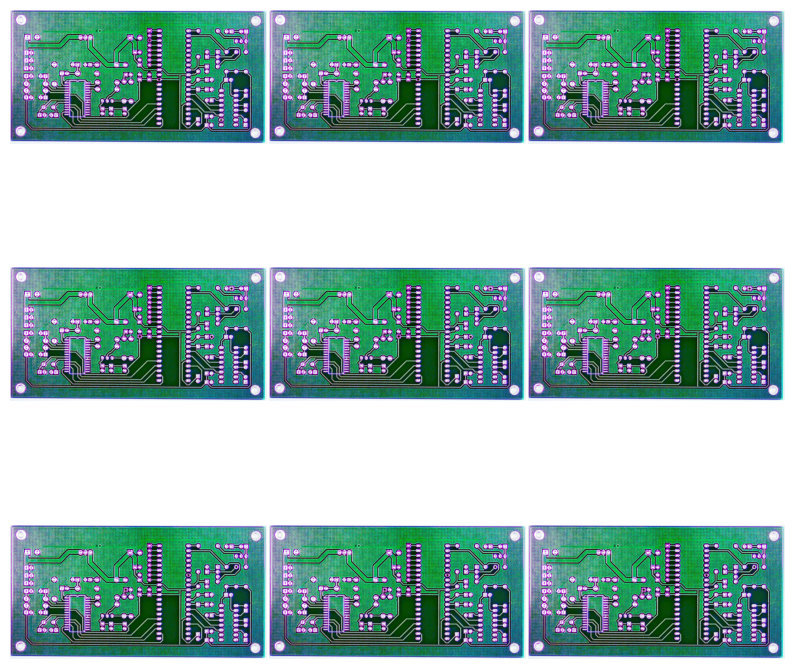

<Figure size 640x480 with 0 Axes>

In [54]:
def equalize_histogram(tf_img):

    cv_img = (tf_img.numpy()).astype('uint8')
    
    # Apply histogram equalization to each of the RGB channels independently
    channels = cv2.split(cv_img)
    eq_channels = [cv2.equalizeHist(ch) for ch in channels]  
    cv2_eq_image = cv2.merge(eq_channels)
    
    tf_eq_image = tf.convert_to_tensor(cv2_eq_image, dtype=tf.int16) 
    
    return tf_eq_image

# image_dataset_equalized = image_dataset.map(equalize_histogram) # Not recommended, as Tensorflow tries to integrate the cv2 functionality to a computational graph.
image_dataset_equalized = image_dataset.map(lambda img: tf.py_function(func=equalize_histogram, inp=[img], Tout=tf.int16))  # Eager execution, no computational graph.

plot_images_from_dataset(image_dataset_equalized)

The images ploted above show a higher contrast comperad to the input images. The improved contrast can help in defect detection, as subtle differences are more visible.
However, it seems also to have introduced or amplified noise. Therefore in the next step the images will be subject to noise reduction. 

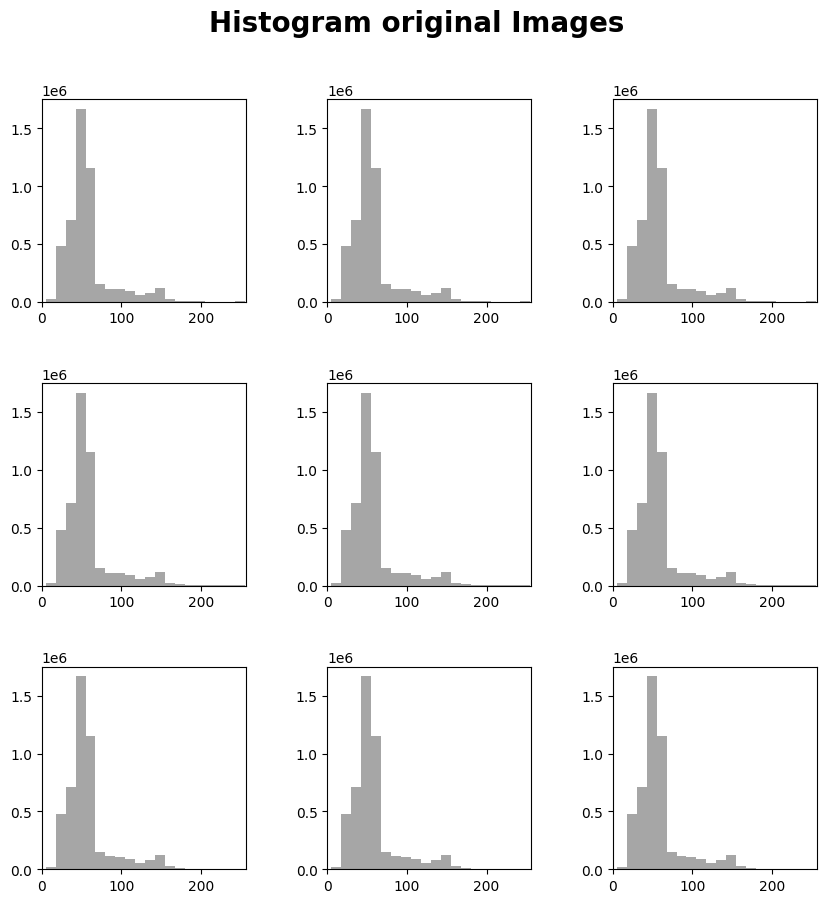

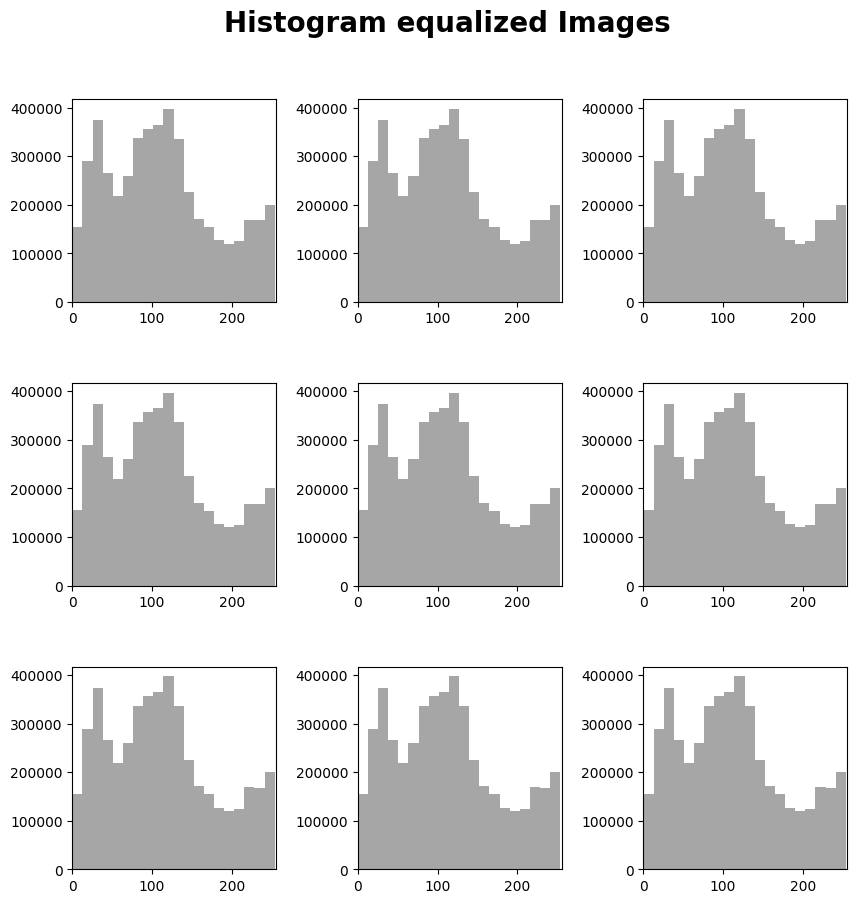

In [87]:
plot_histograms_from_dataset(image_dataset, 'Histogram original Images')
plot_histograms_from_dataset(image_dataset_equalized, 'Histogram equalized Images')

### Noise Reduction

In [109]:
def plot_frequency_spectrum_3D(image_dataset, title="Frequency Spectrum of Images"):

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)

    for i, image in enumerate(image_dataset.take(9)):
        
        ax = fig.add_subplot(3, 3, i+1, projection='3d')
        image_np = tf.image.rgb_to_grayscale(image).numpy().squeeze()

        f_transform = np.fft.fft2(image_np)
        f_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.abs(f_shift)

        # Create a meshgrid for 3D plotting
        x = np.linspace(0, magnitude_spectrum.shape[0]-1, magnitude_spectrum.shape[0])
        y = np.linspace(0, magnitude_spectrum.shape[1]-1, magnitude_spectrum.shape[1])
        X, Y = np.meshgrid(y, x)

        # Plot the surface
        ax.plot_surface(X, Y, np.log(1 + magnitude_spectrum), cmap='viridis')

        ax.set_xlabel("Frequency X")
        ax.set_ylabel("Frequency Y")
        ax.set_zlabel("Magnitude")

    plt.tight_layout()
    plt.show()

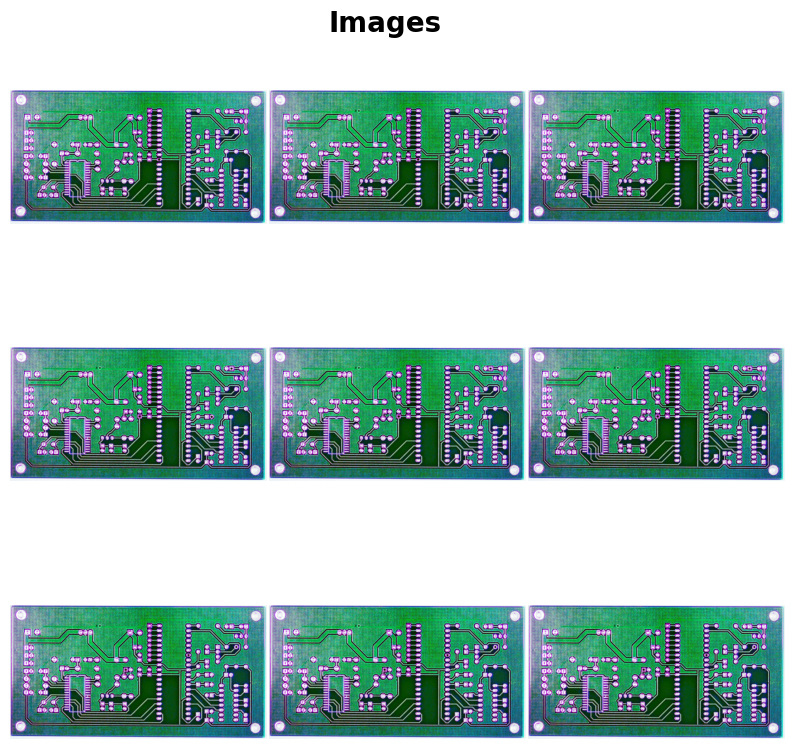

In [94]:
def gaussian_blur(tf_img, kernel_size=(5, 5)):
    cv_img = (tf_img.numpy()).astype('uint8')
    
    cv_blurred_image = cv2.GaussianBlur(cv_img, kernel_size, 0)
    
    tf_blurred_image = tf.convert_to_tensor(cv_blurred_image, dtype=tf.int16)
    
    return tf_blurred_image

image_dataset_blurred = image_dataset_equalized.map(lambda img: tf.py_function(func=gaussian_blur, inp=[img], Tout=tf.int16))

plot_images_from_dataset(image_dataset_blurred)

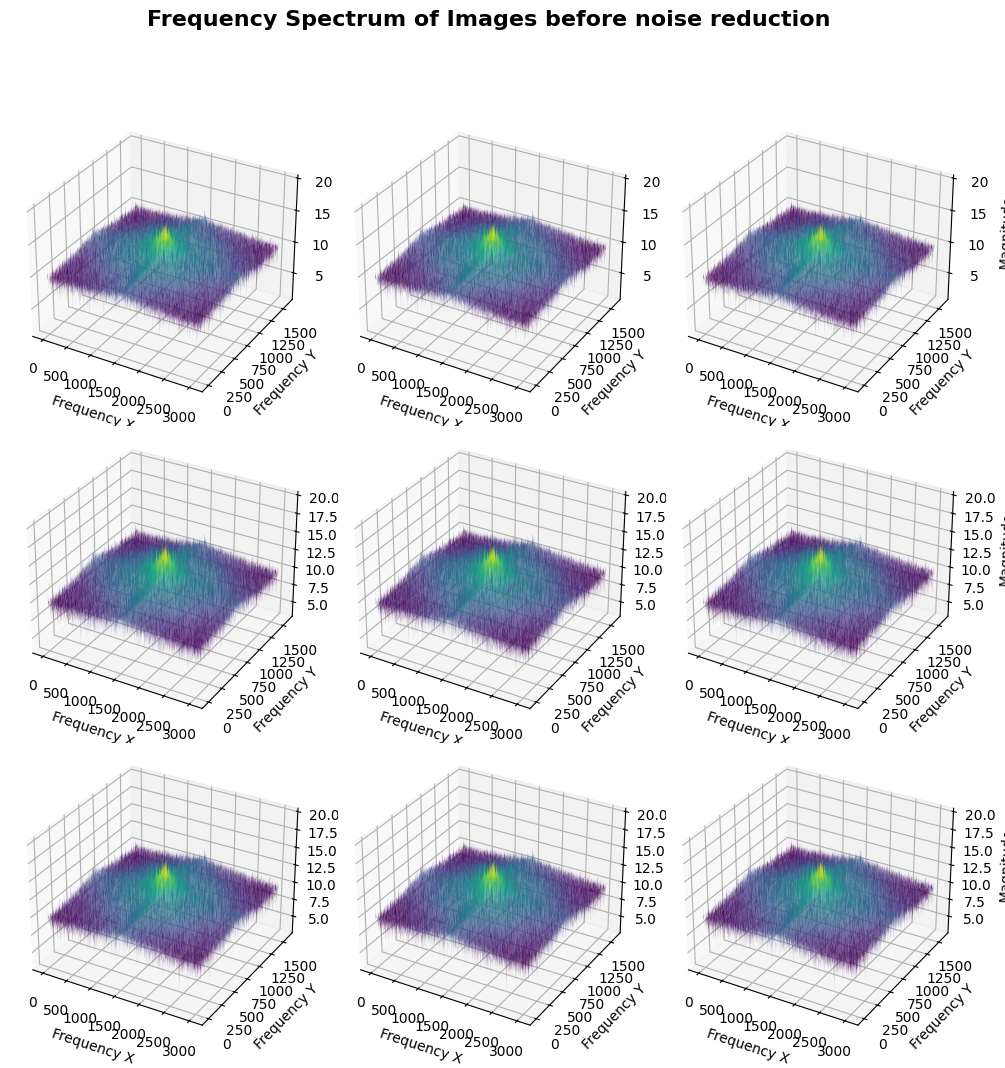

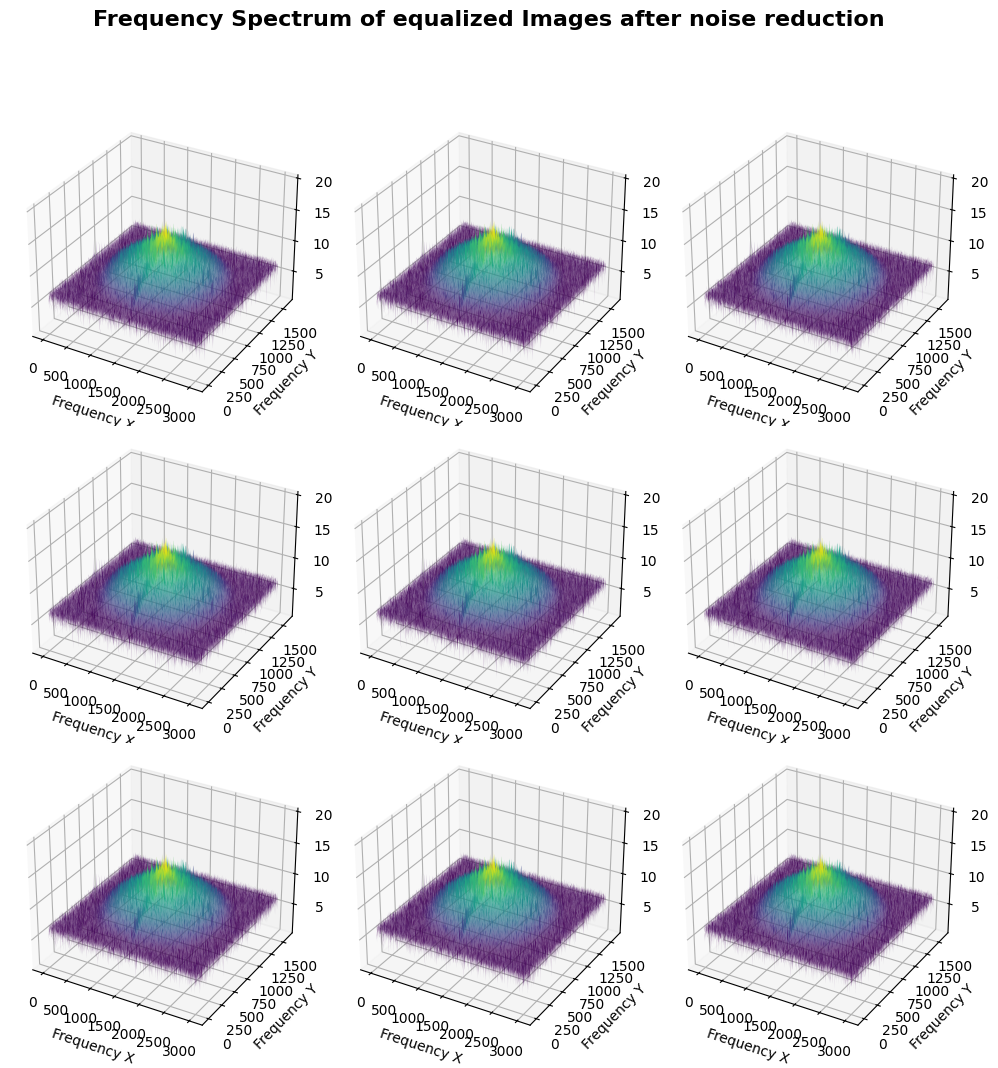

In [110]:
plot_frequency_spectrum_3D(image_dataset_equalized, 'Frequency Spectrum of Images before noise reduction')
plot_frequency_spectrum_3D(image_dataset_blurred, 'Frequency Spectrum of equalized Images after noise reduction')

### Image Shapes

In [ ]:
widths = []
heights = []

for image in image_dataset:  
    shape = image.shape
    widths.append(shape[0])  
    heights.append(shape[1]) 

widths = np.array(widths)
heights = np.array(heights)

print("Mean Width:", widths.mean())
print("Mean Height:", heights.mean())
print("Std Dev Width:", widths.std())
print("Std Dev Height:", heights.std())
print("Min Width:", widths.min())
print("Min Height:", heights.min())
print("Max Width:", widths.max())
print("Max Height:", heights.max())


Mean Width: 2157.239756180156
Mean Height: 2736.1876058245853
Std Dev Width: 274.6939498536975
Std Dev Height: 265.22556582554705
Min Width: 1586
Min Height: 2240
Max Width: 2530
Max Height: 3056


### Image Resizing
The statitistics of the image shapes are useful to find the fixed shape to which the images will be resized.
The image will be resized to a square shape. Before resizing the images are brougth to a squared shape with padding.

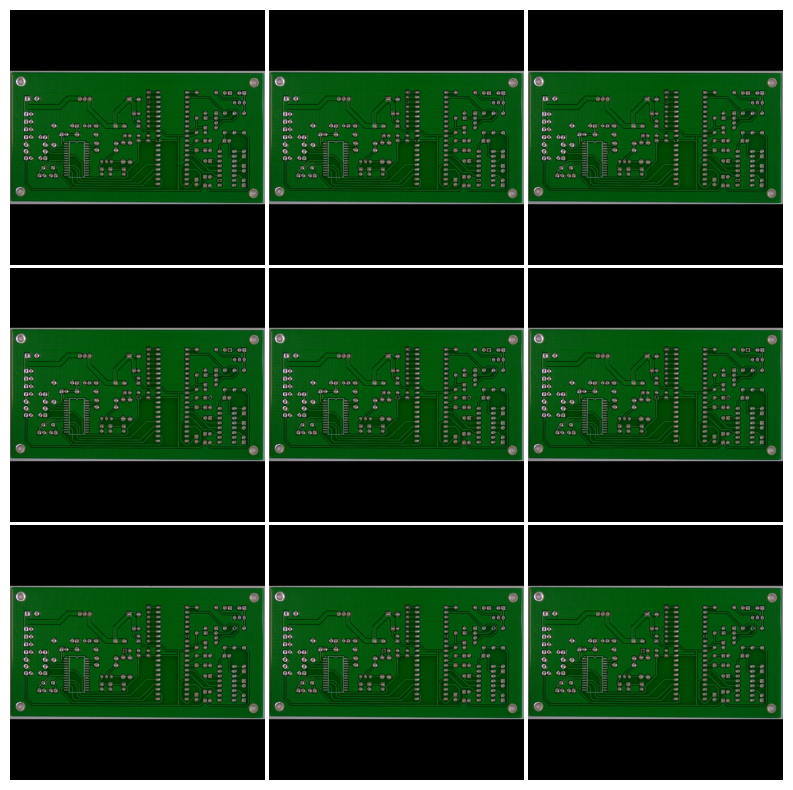

<Figure size 640x480 with 0 Axes>

In [ ]:
DESIRED_H_AND_W = 00

def resize_image(tf_img):
    shape = tf.shape(tf_img)
    height, width = shape[0], shape[1]

    if height > width:
        pad_top = 0
        pad_bottom = 0
        pad_left = (height - width) // 2
        pad_right = height - width - pad_left
    else:
        pad_top = (width - height) // 2
        pad_bottom = width - height - pad_top
        pad_left = 0
        pad_right = 0

    tf_padded_img = tf.pad(tf_img, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
    tf_resized_image = tf.image.resize(tf_padded_img, [DESIRED_H_AND_W, DESIRED_H_AND_W], method='nearest')

    return tf_resized_image 


image_dataset_resized = image_dataset.map(resize_image)
plot_images_from_dataset(image_dataset_resized)